# MIRI LRS Slit Spectroscopy: Spectral Extraction using the JWST Pipeline

**Authors:** Sarah Kendrew, Ian Wong; MIRI branch<br>
**Last Updated:** December 17, 2025<br>
**Pipeline Version:** 1.20.2 (Build 12.1)

**Purpose:** <br>
The aim of this notebook is to demonstrate the custom spectral extraction capabilities of the JWST calibration pipeline. The JWST calibration pipeline performs spectral extraction for all spectroscopic data using a set of basic default assumptions that are tuned to produce accurately calibrated spectra for the majority of science cases. In the case of MIRI LRS data obtained in the slit, the default method is a simple 8-pixel-wide boxcar extraction, where the spectrum is summed along the cross-dispersion axis over the valid wavelength range. An aperture correction is applied at each wavelength element along the spectrum to account for flux lost from the finite-width aperture. 

The ``extract_1d`` step uses the following inputs for its algorithm:
- the spectral extraction reference file: this is a json-formatted file, available as a reference file from the [JWST Calibration Reference Data System (CRDS)](https://jwst-crds.stsci.edu)
- the bounding box: the ``assign_wcs`` step attaches a bounding box definition to the data, which defines the region over which a valid calibration is available. We will demonstrate below how to visualize this region. 

Beyond simple boxcar extraction, the ``extract_1d`` step has the capability to perform more complex spectral extractions, which require the user to manually edit some of the parameters contained in the spectral extraction reference file and rerun the pipeline step. 

**Data:** <br>
The data used in this notebook is an observation of the Type Ia supernova SN2021aefx, observed by Jha et al. in Program #2072 (Observation 1). These data were taken with zero exclusive access period and published in [Kwok et al 2023](https://ui.adsabs.harvard.edu/abs/2023ApJ...944L...3K/abstract). The relevant data files are located in the compressed ``data.zip`` file and will be automatically unpacked and placed in a subdirectory called ``data/``. The user can also manually specify a particular set of input files of their choice below.

We will demonstrate most of the spectral extraction methods on resampled, calibrated spectral images (``s2d`` files). The basic demo and many examples run on Level 3 data, in which the pair of nodded exposures has been combined into a single spectral image. Several of the other examples use a Level 2b data file, corresponding to just the first of the two nodded exposures. For optimal spectral extraction (Example 5), the pipeline requires unrectified, calibrated spectral images (``cal`` files).<br>


**JWST pipeline version and CRDS context:** <br>
This notebook was written for the above-specified pipeline version and associated build context for this version of the JWST Calibration Pipeline. Information about this and other contexts can be found in the JWST CRDS [server](https://jwst-crds.stsci.edu/)). If you use different pipeline versions, please refer to the table [here](https://jwst-crds.stsci.edu/display_build_contexts/) to determine what context to use. To learn more about the differences for the pipeline, read the relevant [documentation](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline/jwst-operations-pipeline-build-information#references).

Please note that pipeline software development is a continuous process, so results in some cases may be slightly different if a subsequent version is used. **For optimal results, users are strongly encouraged to reprocess their data using the most recent pipeline version and [associated CRDS context](https://jwst-crds.stsci.edu/display_build_contexts/), taking advantage of bug fixes and algorithm improvements.** Any [known issues](https://jwst-docs.stsci.edu/known-issues-with-jwst-data#gsc.tab=0) for this build are noted in the notebook.


**Documentation:** <br>
This notebook is part of a STScI's larger [post-pipeline Data Analysis Tools Ecosystem](https://jwst-docs.stsci.edu/jwst-post-pipeline-data-analysis) and can be [downloaded](https://github.com/spacetelescope/dat_pyinthesky/tree/main/jdat_notebooks/MRS_Mstar_analysis) directly from the [JDAT Notebook Github directory](https://github.com/spacetelescope/jdat_notebooks).

**Recent updates:** <br>
July 2023: First public version of notebook created<br>
December 17, 2025: Formatting cleanup and updates. Added optimal spectral extraction and updated background subtraction examples.

<hr style="border:1px solid gray"> </hr>

## Table of Contents

0. [Package imports](#Package-imports)
1. [The Level 2 & 3 data products](#The-Level-2-&-3-data-products)
2. [The spectral extraction reference file](#The-spectral-extraction-reference-file)
3. [Example 1: Changing the extraction aperture width](#Example-1:-Changing-the-extraction-aerture-width)
4. [Example 2: Changing the extraction aperture location](#Example-2:-Changing-the-extraction-aperture-location)
5. [Example 3: Extraction with background subtraction](#Example-3:-Extraction-with-background-subtraction)
6. [Example 4: Tapered column extraction](#Example-4:-Tapered-column-extraction)
7. [Example 5: Optimal spectral extraction](#Example-5:-Optimal-spectral-extraction)

<hr style="border:1px solid gray"> </hr>

## Package imports<a class="anchor" id="intro"></a>

It is assumed that the user has installed a number of relevant dependencies, which are listed below. If this is not the case, the missing dependencies can be installed using ``pip``. We recommend that the user create a dedicated conda environment for running the pipeline and installing dependencies.

- `astropy.io.fits` for accessing FITS files
- `os` for managing system paths
- `matplotlib` for plotting data
- `urllib` for downloading data
- `zipfile` for unpacking data
- `numpy` for basic array manipulation
- `jwst` for running JWST pipeline and handling data products
- `json` for working with json files
- `crds` for working with JWST reference files

In [1]:
import os

# ------------------------Set CRDS context and paths----------------------
# Each version of the calibration pipeline is associated with a specific CRDS
# context file. The pipeline will select the appropriate context file behind
# the scenes while running. However, if you wish to override the default context
# file and run the pipeline with a different context, you can set that using
# the CRDS_CONTEXT environment variable. Here we show how this is done,
# although we leave the line commented out in order to use the default context.

# If you wish to specify a different context, uncomment the line below.
#os.environ['CRDS_CONTEXT'] = 'jwst_1322.pmap'  # CRDS context for 1.17.1

# Check whether the local CRDS cache directory has been set.
# If not, set it to the user home directory.
if (os.getenv('CRDS_PATH') is None):
    os.environ['CRDS_PATH'] = os.path.join(os.path.expanduser('~'), 'crds_cache')
    
# Check whether the CRDS server URL has been set.  If not, set it.
if (os.getenv('CRDS_SERVER_URL') is None):
    os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'

# Print out CRDS path and context that will be used
print('CRDS local filepath:', os.environ['CRDS_PATH'])
print('CRDS file server:', os.environ['CRDS_SERVER_URL'])

CRDS local filepath: /Users/iwong/crds_cache
CRDS file server: https://jwst-crds.stsci.edu


In [47]:
%matplotlib inline
import urllib
import zipfile

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.colors as colors

import astropy.io.fits as fits
import astropy.units as u
from astropy.modeling import models, fitting

# JWST calibration pipeline and extract_1d step
import jwst
from jwst import datamodels
from jwst.extract_1d import Extract1dStep

import json
import crds

print(f'Using JWST calibration pipeline version {jwst.__version__}')

Using JWST calibration pipeline version 1.20.2


Now we download the data that will be used by this notebook.

In [48]:
data_zip_file = 'data.zip'

# Uunpack data, if needed
if not os.path.exists('data/'):
    print('Unpacking Data')
    with zipfile.ZipFile(data_zip_file, 'r') as zip_ref:
        zip_ref.extractall('data/')

<hr style="border:1px solid gray"> </hr>

## The Level 2 & 3 data products<a class="anchor" id="l3data"></a>

The ``data/`` subdirectory contains both Level 2 and Level 3 data products. There are two relevant Level 3 data files:
* the ``s2d`` file: this is the flux-calibrated 2D image built from the co-added resampled individual nod exposures. 
* the ``x1d`` file: this is the 1-D extracted spectrum, which is extracted from the Level 3 ``s2d`` file by the calibration pipeline using default settings.

The Level 3 ``s2d`` image shows a bright central trace, flanked by two negative traces. These result from the combination of the nod exposures, each of which contains a positive and negative trace due to the mutual subtraction of the two nodded exposures. 

In [4]:
l3_s2d_file = 'data/jw02072-o001_t001_miri_p750l_s2d.fits'
l3_x1d_file = 'data/jw02072-o001_t001_miri_p750l_x1d.fits'

We now plot the Level 3 spectral image and extracted spectrum. The flux unit in the spectral image is MJy/steradian. When plotting the spectrum, the short-wavelength end of the x-axis is restricted to 5 microns, as the flux calibration is very poor below this wavelength. 

/var/folders/15/2bqy5cl94jq15mlyt1vnkls40005sl/T/ipykernel_34091/23872220.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


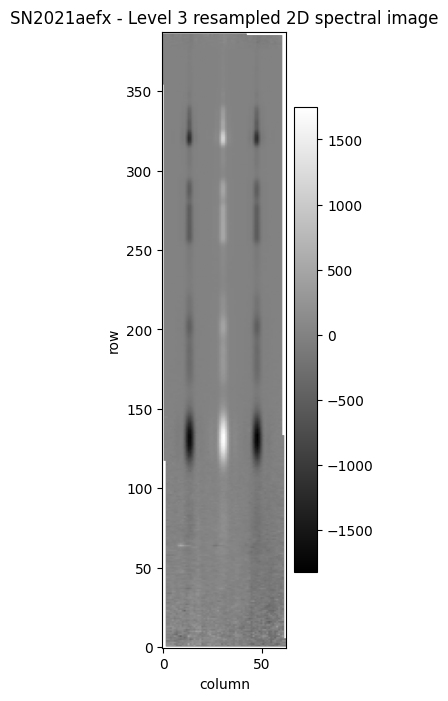

In [5]:
l3_s2d = datamodels.open(l3_s2d_file)

fig, ax = plt.subplots(figsize=[2, 8])
im2d = ax.imshow(l3_s2d.data, origin='lower', aspect='auto', cmap='gist_gray')
ax.set_xlabel('column')
ax.set_ylabel('row')
ax.set_title('SN2021aefx - Level 3 resampled 2D spectral image')
fig.colorbar(im2d)
fig.show()

/var/folders/15/2bqy5cl94jq15mlyt1vnkls40005sl/T/ipykernel_34091/2913078293.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig2.show()


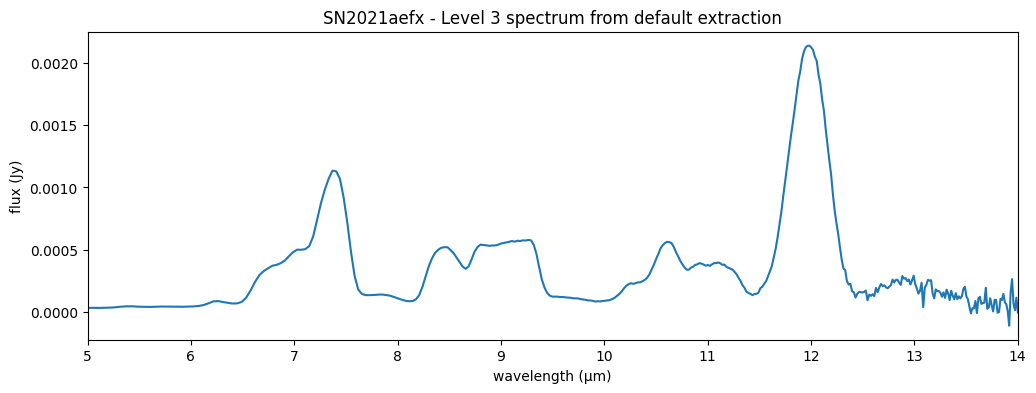

In [6]:
l3_spec = datamodels.open(l3_x1d_file)

fig2, ax2 = plt.subplots(figsize=[12, 4])
ax2.plot(l3_spec.spec[0].spec_table['WAVELENGTH'], l3_spec.spec[0].spec_table['FLUX'])
ax2.set_xlabel('wavelength (μm)')
ax2.set_ylabel('flux (Jy)')
ax2.set_title('SN2021aefx - Level 3 spectrum from default extraction')
ax2.set_xlim(5., 14.)
fig2.show()

The data subdirectory also contains two different versions of the Level 2 ``s2d`` file for the first nodded exposure. Both of them are resampled and rectified spectral images produced by the second stage of the calibration pipeline. The default file ``l2_s2d_file`` follows the standard pipeline procedure of pairwise nod subtraction and shows a single pair of positive and negative traces. The ``l2_s2d_file_nobsub`` file was custom generated with the background subtraction step skipped and therefore only contains a positive trace. For a general overview of custom pipeline processing, refer to the [MIRI LRS Slit Mode Pipeline Notebook](https://github.com/spacetelescope/jwst-pipeline-notebooks/blob/main/notebooks/MIRI/LRS-slit/JWPipeNB-MIRI-LRS-slit.ipynb). The choice to skip nod subtraction may be motivated by the presence of additional sources within the slit or an extended target. The ``extract_1d`` step provides flexible options for customized background subtraction for instances where simple mutual subtraction of the nodded exposures is not appropriate.

In [7]:
l2_s2d_file = 'data/jw02072001001_06101_00001_mirimage_s2d.fits'
l2_s2d_file_nobsub = 'data/jw02072001001_06101_00001_mirimage_s2d_nobsub.fits'

We now plot the Level 2 spectral image generated without pairwise nod subtraction. The background level rises dramatically toward the bottom of the spectral image (i.e., longer wavelengths) and shows a nonuniform distribution along the horizontal direction.

/var/folders/15/2bqy5cl94jq15mlyt1vnkls40005sl/T/ipykernel_34091/3565125081.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


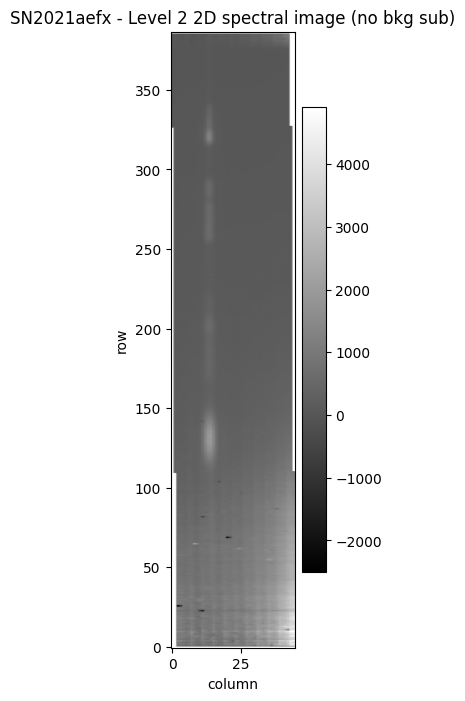

In [8]:
l2_s2d_nobsub = datamodels.open(l2_s2d_file_nobsub)

fig, ax = plt.subplots(figsize=[2, 8])
im2d = ax.imshow(l2_s2d_nobsub.data, origin='lower', aspect='auto', cmap='gist_gray')
ax.set_xlabel('column')
ax.set_ylabel('row')
ax.set_title('SN2021aefx - Level 2 2D spectral image (no bkg sub)')
fig.colorbar(im2d)
fig.show()

Lastly, there are a pair of Level 2 ``cal`` files, which are the respective unrectified spectral images that correspond to the Level 2 ``s2d`` files described above. These images contain the full detector readout and will be used for the optimal spectral extraction example (Example 5).

In [9]:
l2_cal_file = 'data/jw02072001001_06101_00001_mirimage_cal.fits'
l2_cal_file_nobsub = 'data/jw02072001001_06101_00001_mirimage_cal_nobsub.fits'

<hr style="border:1px solid gray"> </hr>

## The spectral extraction reference file<a class="anchor" id="x1dref"></a>

The reference file that handles the parameter settings read in by the ``extract_1d`` step is a plain-text file in the `json` format that is available in [CRDS](https://jwst-crds.stsci.edu). The second reference file used in the extraction is the aperture correction; this file contains vectors that correct for the flux lost as a function of wavelength based on the specific extraction aperture size used. You can use the datamodel attributes of the ``x1d`` file to check which extraction reference file was called by the algorithm. 

We demonstrate below how to examine the file programmatically to see what aperture size was used to produce the default Level 3 spectrum shown above. **Note: this json file can easily be opened and edited with a simple text editor**.  

A full description of the ``extract_1d`` reference file and the parameter definitions is available [here](https://jwst-pipeline.readthedocs.io/en/latest/jwst/extract_1d/reference_files.html).

In [10]:
print(f'Spectral extraction reference file used: {l3_spec.meta.ref_file.extract1d.name}')

Spectral extraction reference file used: crds://jwst_miri_extract1d_0007.json


The same ``extract_1d`` reference file is used by the pipeline for both LRS slit and slitless observations, and each mode has a separate set of default parameters. We can examine those values as follows.

In [11]:
file_path = l3_x1d_file
with fits.open(file_path) as hdul:
    header = hdul[0].header
    json_ref_default = crds.getreferences(header)['extract1d']

    with open(json_ref_default) as json_ref:
        x1dref_default = json.load(json_ref)
        print('Settings for SLIT data: {}'.format(x1dref_default['apertures'][0]))
        print('  ')
        print('Settings for SLITLESS data: {}'.format(x1dref_default['apertures'][1]))

CRDS - INFO -  Calibration SW Found: jwst 1.20.2 (/Users/iwong/miniforge3/envs/jwst/lib/python3.12/site-packages/jwst-1.20.2.dist-info)


Settings for SLIT data: {'id': 'MIR_LRS-FIXEDSLIT', 'region_type': 'target', 'bkg_order': 0, 'dispaxis': 2, 'xstart': 27, 'xstop': 34}
  
Settings for SLITLESS data: {'id': 'MIR_LRS-SLITLESS', 'region_type': 'target', 'bkg_fit': 'median', 'dispaxis': 2, 'xstart': 30, 'xstop': 41, 'bkg_coeff': [[9.5], [17.5], [53.5], [61.5]], 'use_source_posn': False}


Here is a brief breakdown of the parameters that can be included in a MIRI LRS reference file:

* ``id``: identification label that specifies the exposure type (slit vs. slitless) the parameters will be applied to.
* ``region_type``: optional; if included, it must be set to 'target'.
* ``disp_axis``: defines the direction of the dispersion (1 for x-axis, 2 for y-axis). **For MIRI LRS this should always be set to 2.**
* ``xstart`` (int or float): first pixel of the extraction aperture in the horizontal direction (0-indexed).
* ``xstop`` (int or float): last pixel of the extraction aperture in the horizontal direction (0-indexed; the limit is **inclusive**).
* ``ystart`` (int or float): first pixel of the extraction aperture in the vertical direction (0-indexed).
* ``ystop`` (int or float): last pixel of the extraction aperture in the vertical direction (0-indexed; the limit is **inclusive**).
* ``extract_width`` (int or float): width of extraction aperture in the cross-dispersion direction. This parameter takes precedence over the ``xstart`` and ``xstop`` settings. If both are given, the ``xstart`` and ``xstop`` positions are used to determine the location of the spectral trace, but the spectral extraction utilizes an aperture of width equal to ``extract_width``.
* ``bkg_fit``: the type of background fit or computation used; can be 'median', 'mean', or 'poly' (polynomial fitting).
* ``bkg_order``: if ``bkg_fit`` is set to 'poly', this is the polynomial order to be used for background fitting; if the accompanying parameter ``bkg_coeff`` is not provided, no background fitting will be performed. **For MIRI LRS slit data, default background subtraction is achieved in the Spec2Pipeline by mutually subtracting the nodded expsosures, so the basic use case does not require additional background subtraction from the spectral images.**
* ``bkg_coeff``: polynomial coefficients for defining background extraction region limits (list of lists of float); single-entry lists are interpreted as vertical boundaries.
* ``src_coeff``: polynomial coefficients for the source extraction region limits (list of lists of float); this setting takes precedence over the start/stop values if both are provided.
* ``smoothing_length`` (odd int): width of the boxcar kernel used for smoothing the background regions along the dispersion direction.
* ``independent_var``: variable against which the ``bkg_coeff`` and ``src_coeff`` values are defined; can be 'wavelength' or 'pixel'.
* ``use_source_posn`` (True/False/None): if set to True, the pipeline will use the target coordinates to locate the target along the slit and move the center of the extraction aperture to this location; if set to None, the aperture shift will be carried out for point sources only.

Note that in addition to the ``extract_1d`` reference file, the spectral extraction parameter settings can also be adjusted at the pipeline level. For example, the current default pipeline workflow sets ``use_source_posn`` = True for Stage 2 processing of all LRS slit data, due to the nodded exposures; however, ``use_source_posn`` is set to False for Stage 3 processing, where the combined resampled spectrum is typically at a nominal position.

For MIRI LRS, the dispersion is in the vertical direction (i.e. `disp_axis` = 2), and so the extraction aperture width is specified with the coordinates `xstart` and `xstop`. If `ystart` and `ystop` are not provided, the spectrum will be extracted over the full height of the ``s2d`` cutout region. We can illustrate the default extraction region in the Level 3 ``s2d`` file. 


/var/folders/15/2bqy5cl94jq15mlyt1vnkls40005sl/T/ipykernel_34091/2020159514.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


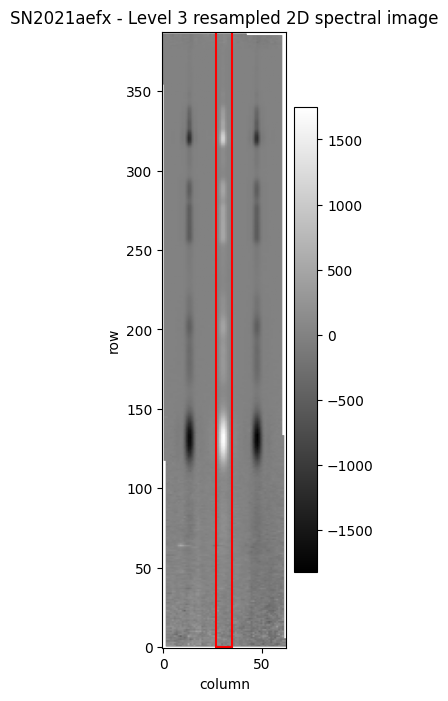

In [12]:
xstart = x1dref_default['apertures'][0]['xstart']
xstop = x1dref_default['apertures'][0]['xstop']
ap_height = np.shape(l3_s2d.data)[0]     # no ystart/ystop provided, so the aperture extends the full height
ap_width = xstop - xstart + 1
x1d_rect = Rectangle(xy=(xstart, 0), width=ap_width, height=ap_height, angle=0., edgecolor='red',
                     facecolor='None', ls='-', lw=1.5)

fig, ax = plt.subplots(figsize=[2, 8])
im2d = ax.imshow(l3_s2d.data, origin='lower', aspect='auto', cmap='gist_gray')
ax.add_patch(x1d_rect)
ax.set_xlabel('column')
ax.set_ylabel('row')
ax.set_title('SN2021aefx - Level 3 resampled 2D spectral image')
fig.colorbar(im2d)
fig.show()

<hr style="border:1px solid gray"> </hr>

## Example 1: Changing the extraction aperture width<a class="anchor" id="ex1"></a>

In this example, we demonstrate how to change the extraction width from the default 8 pixels to 12 pixels while keeping the aperture centred on the trace. 

Here, we modify the values programmatically, having previously read in the default settings from the spectral extraction reference file. In practice, the values can also be simply edited in the reference file using a text editor. **Note: because the default ``extract_1d`` parameter file does not have ``use_source_posn`` set, the ``extract_1d`` step assumes that it is set to None and will activate the source finder for point sources. To explicitly fix the extraction region programmatically, we must set ``use_source_posn`` = False.**

In [13]:
xstart2 = xstart - 2
xstop2 = xstop + 2
print('New xstart, xstop values = {0}, {1}'.format(xstart2, xstop2))

# Replace default values
with open(json_ref_default) as json_ref:
    x1dref_default = json.load(json_ref)
    x1dref_ex1 = x1dref_default.copy()
    x1dref_ex1['apertures'][0]['use_source_posn'] = False
    x1dref_ex1['apertures'][0]['xstart'] = xstart2
    x1dref_ex1['apertures'][0]['xstop'] = xstop2

# Save new reference file
with open('x1d_reffile_example1.json', 'w') as jsrefout:
    json.dump(x1dref_ex1, jsrefout, indent=4)

New xstart, xstop values = 25, 36


We now overplot the two apertures (default vs. custom) on the Level 3 spectral image.

/var/folders/15/2bqy5cl94jq15mlyt1vnkls40005sl/T/ipykernel_34091/1169779306.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig4.show()


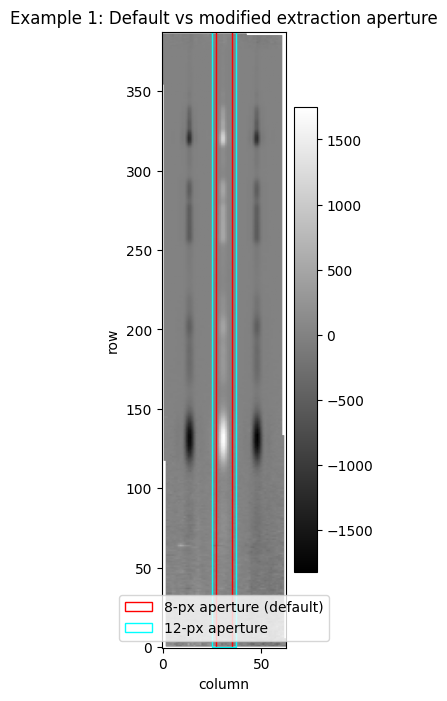

In [14]:
ap_width2 = xstop2 - xstart2 + 1
x1d_rect1 = Rectangle(xy=(xstart, 0), width=ap_width, height=ap_height, angle=0., edgecolor='red',
                      facecolor='None', ls='-', lw=1, label='8-px aperture (default)')

x1d_rect2 = Rectangle(xy=(xstart2, 0), width=ap_width2, height=ap_height, angle=0., edgecolor='cyan',
                      facecolor='None', ls='-', lw=1, label='12-px aperture')

fig4, ax4 = plt.subplots(figsize=[2, 8])
im2d = ax4.imshow(l3_s2d.data, origin='lower', aspect='auto', cmap='gist_gray')
# ax4.add_collection(aps_collection)
ax4.add_patch(x1d_rect1)
ax4.add_patch(x1d_rect2)

ax4.set_xlabel('column')
ax4.set_ylabel('row')
ax4.set_title('Example 1: Default vs modified extraction aperture')
ax4.legend(loc='lower center')
fig4.colorbar(im2d)
fig4.show()

Next, we run the spectral extraction step using this modified reference file. **Note: when a step is run individually, the file name suffix is different from when the Spec3Pipeline is run in its entirety.** The extracted spectrum will now have ``extract1dstep.fits`` in the filename. 

To use the new modified reference file and customize the output filename for specificity, we pass two custom parameters to the step call:

* ``output_file``: the custom output filename for this example (including an output filename renders the ``save_results`` parameter obsolete)
* ``override_extract1d``: (relative or absolute) path to the modified reference file we created above

In [15]:
sp3_ex1 = Extract1dStep.call(l3_s2d, output_dir='data/', 
                             output_file='lrs_slit_extract_example1', override_extract1d='x1d_reffile_example1.json')

2025-12-17 13:31:16,643 - stpipe.step - INFO - Extract1dStep instance created.
2025-12-17 13:31:16,682 - stpipe.step - INFO - Step Extract1dStep running with args (<SlitModel(388, 63) from jw02072-o001_t001_miri_p750l_s2d.fits>,).
2025-12-17 13:31:16,684 - stpipe.step - INFO - Step Extract1dStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: /Users/iwong/Documents/Astro/STScI/pipeline_testing/jdat_notebooks/notebooks/MIRI/MIRI_LRS_spectral_extraction/lrs_slit_extract_example1
  output_dir: data/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: False
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  subtract_background: None
  apply_apcorr: True
  extraction_type: box
  use_source_posn: None
  position_offset: 0.0
  model_nod_pair: True
  optimize_psf_location: True
  smoothing_length: None
  bkg_fit: None
  bkg_order: None
  log_increment: 50
  save_profile: False
  save_scene_model: False
  save_residual_im

We now plot the spectrum from the modified extration against the default spectrum. Recall that the spectral extraction includes an aperture correction that accounts for the flux loss outside of the aperture, and so the spectra should be largely identical in flux level throughout. Minor differences can be apparent at longer wavelengths as the aperture correction is less well-calibrated in this low SNR region. 

/var/folders/15/2bqy5cl94jq15mlyt1vnkls40005sl/T/ipykernel_34091/3136163026.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig5.show()


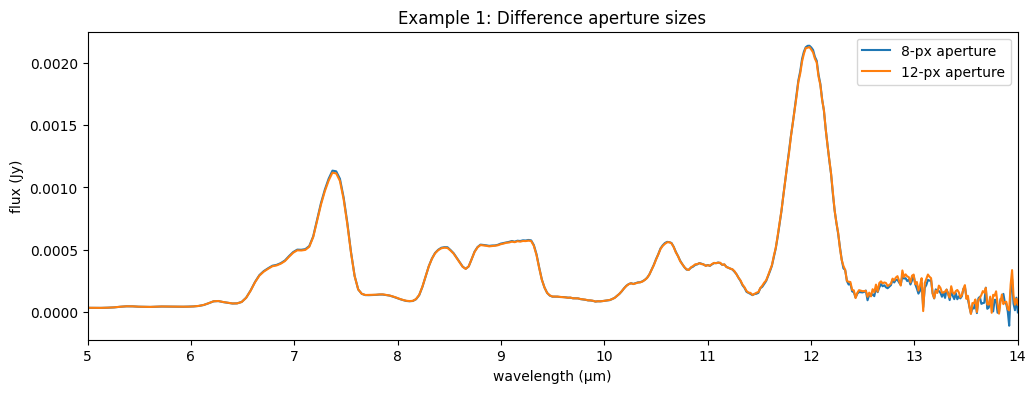

In [16]:
fig5, ax5 = plt.subplots(figsize=[12, 4])
ax5.plot(l3_spec.spec[0].spec_table['WAVELENGTH'], l3_spec.spec[0].spec_table['FLUX'], label='8-px aperture')
ax5.plot(sp3_ex1.spec[0].spec_table['WAVELENGTH'], sp3_ex1.spec[0].spec_table['FLUX'], label='12-px aperture')
ax5.set_xlabel('wavelength (μm)')
ax5.set_ylabel('flux (Jy)')
ax5.set_title('Example 1: Difference aperture sizes')
ax5.set_xlim(5., 14.)
ax5.legend()
fig5.show()

<hr style="border:1px solid gray"> </hr>

## Example 2: Changing the extraction aperture location<a class="anchor" id="ex2"></a>

In this example, we demonstrate how to adjust the location of the spectral extraction region. A good use case for this is extracting the spectrum from one of the Level 2 nodded exposures. We will take the ``s2d`` output from the Spec2Pipeline and extract the spectrum. 

For the first nodded exposure, the spectral trace is centered at column 13 (0-indexed). There are two ways we can adjust the aperture location. First, we can manually adjust the ``xstart`` and ``xstop`` values to account for the actual location of the spectral trace.

In [17]:
l2_s2d = datamodels.open(l2_s2d_file)

In [18]:
xstart3 = 9
xstop3 = 16

with open(json_ref_default) as json_ref:
    x1dref_default = json.load(json_ref)
    x1dref_ex2 = x1dref_default.copy()
    x1dref_ex2['apertures'][0]['use_source_posn'] = False
    x1dref_ex2['apertures'][0]['xstart'] = xstart3
    x1dref_ex2['apertures'][0]['xstop'] = xstop3

with open('x1d_reffile_example2a.json', 'w') as jsrefout:
    json.dump(x1dref_ex2, jsrefout, indent=4)

/var/folders/15/2bqy5cl94jq15mlyt1vnkls40005sl/T/ipykernel_34091/165406601.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig6.show()


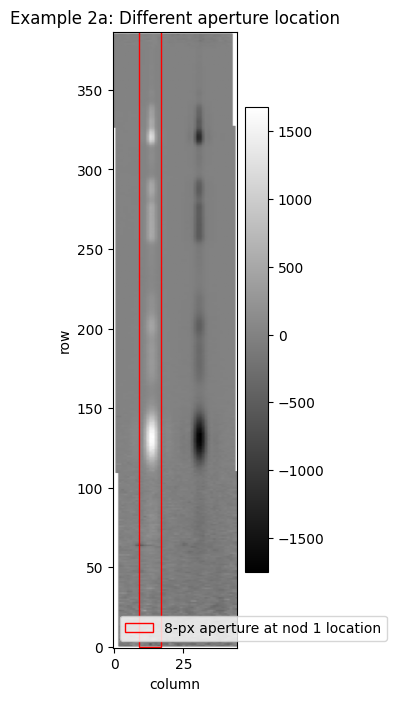

In [19]:
ap_width3 = xstop3 - xstart3 + 1
x1d_rect3 = Rectangle(xy=(xstart3, 0), width=ap_width3, height=ap_height, angle=0., edgecolor='red',
                      facecolor='None', ls='-', lw=1, label='8-px aperture at nod 1 location')

fig6, ax6 = plt.subplots(figsize=[2, 8])
im2d = ax6.imshow(l2_s2d.data, origin='lower', aspect='auto', cmap='gist_gray')
ax6.add_patch(x1d_rect3)
ax6.set_xlabel('column')
ax6.set_ylabel('row')
ax6.set_title('Example 2a: Different aperture location')
ax6.legend(loc=3)
fig6.colorbar(im2d)
fig6.show()

As before, we pass the modified reference file to the ``extract_1d`` step call.

In [20]:
sp2_ex2a = Extract1dStep.call(l2_s2d_file, output_dir='data/', output_file='lrs_slit_extract_example2a',
                             override_extract1d='x1d_reffile_example2a.json')

2025-12-17 13:31:17,380 - stpipe.step - INFO - Extract1dStep instance created.
2025-12-17 13:31:17,421 - stpipe.step - INFO - Step Extract1dStep running with args ('data/jw02072001001_06101_00001_mirimage_s2d.fits',).
2025-12-17 13:31:17,423 - stpipe.step - INFO - Step Extract1dStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: /Users/iwong/Documents/Astro/STScI/pipeline_testing/jdat_notebooks/notebooks/MIRI/MIRI_LRS_spectral_extraction/lrs_slit_extract_example2a
  output_dir: data/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: False
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  subtract_background: None
  apply_apcorr: True
  extraction_type: box
  use_source_posn: None
  position_offset: 0.0
  model_nod_pair: True
  optimize_psf_location: True
  smoothing_length: None
  bkg_fit: None
  bkg_order: None
  log_increment: 50
  save_profile: False
  save_scene_model: False
  save_residual_image: False
 

Let's again plot the output against the default extracted product. We expect this single-nod spectrum to be noisier but not significantly different from the combined product. The spectrum may have more bad pixels that manifest as spikes or dips in the spectrum. Deviations at long wavelengths stem from imperfections in the photometric calibration in that region; the standard stars used for calibration have low SNR at the longest wavelengths. Moreover, the flux calibration of the MIRI LRS instrument is currently based off of Level 3 nod-combined spectra and therefore does not readily account for possible spatial variations in the sensitivity across the detector.

/var/folders/15/2bqy5cl94jq15mlyt1vnkls40005sl/T/ipykernel_34091/4204974081.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig7.show()


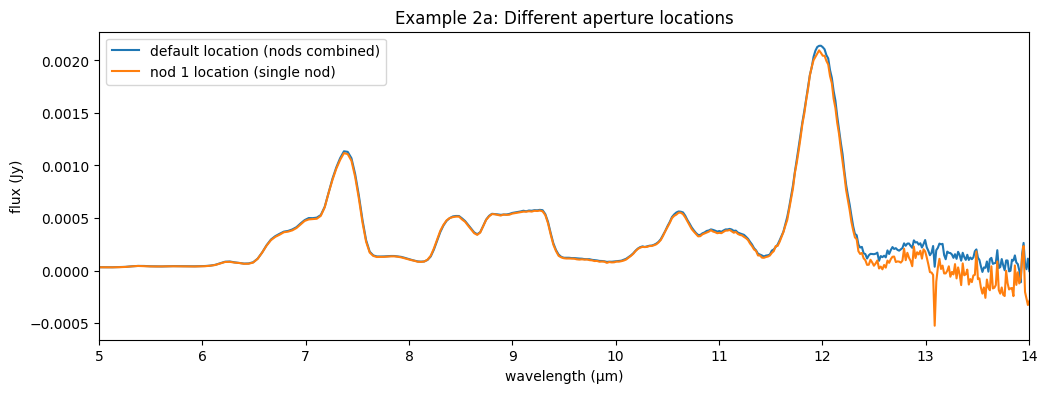

In [21]:
fig7, ax7 = plt.subplots(figsize=[12, 4])
ax7.plot(l3_spec.spec[0].spec_table['WAVELENGTH'], l3_spec.spec[0].spec_table['FLUX'], label='default location (nods combined)')
ax7.plot(sp2_ex2a.spec[0].spec_table['WAVELENGTH'], sp2_ex2a.spec[0].spec_table['FLUX'], label='nod 1 location (single nod)')
ax7.set_xlabel('wavelength (μm)')
ax7.set_ylabel('flux (Jy)')
ax7.set_title('Example 2a: Different aperture locations')
ax7.set_xlim(5., 14.)
ax7.legend()
fig7.show()

Alternatively, we can set ``use_source_posn`` to True and let the pipeline determine the location of the aperture based on the pointing information stored in the file header. As long as the target acquisition executed nominally, the header information will reliably account for the offset between the nod positions, allowing the ``extract_1d`` step to shift the aperture appropriately. 

Because we care primarily about the width of the extraction region (8 pixels in this case), we can set the ``extract_width`` parameter to 8, which will automatically establish an 8-pixel-wide boxcar aperture centered on the precise pixel location of the source spectral trace determined by the ``extract_1d`` routine.

In [22]:
with open(json_ref_default) as json_ref:
    x1dref_default = json.load(json_ref)
    x1dref_ex2 = x1dref_default.copy()
    x1dref_ex2['apertures'][0]['use_source_posn'] = True
    x1dref_ex2['apertures'][0]['extract_width'] = 8

with open('x1d_reffile_example2b.json', 'w') as jsrefout:
    json.dump(x1dref_ex2, jsrefout, indent=4)

In [23]:
sp2_ex2b = Extract1dStep.call(l2_s2d_file, output_dir='data/', output_file='lrs_slit_extract_example2b',
                             override_extract1d='x1d_reffile_example2b.json')

2025-12-17 13:31:17,892 - stpipe.step - INFO - Extract1dStep instance created.
2025-12-17 13:31:17,939 - stpipe.step - INFO - Step Extract1dStep running with args ('data/jw02072001001_06101_00001_mirimage_s2d.fits',).
2025-12-17 13:31:17,942 - stpipe.step - INFO - Step Extract1dStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: /Users/iwong/Documents/Astro/STScI/pipeline_testing/jdat_notebooks/notebooks/MIRI/MIRI_LRS_spectral_extraction/lrs_slit_extract_example2b
  output_dir: data/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: False
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  subtract_background: None
  apply_apcorr: True
  extraction_type: box
  use_source_posn: None
  position_offset: 0.0
  model_nod_pair: True
  optimize_psf_location: True
  smoothing_length: None
  bkg_fit: None
  bkg_order: None
  log_increment: 50
  save_profile: False
  save_scene_model: False
  save_residual_image: False
 

Let's retrieve the aperture boundary locations determined by the spectral extraction. Note that the boundary information stored in the metadata is (usually) 1-indexed, unlike the 0-indexed convention used in the ``extract_1d`` reference file.

In [24]:
xstart4, xstop4 = sp2_ex2b.spec[0].extraction_xstart, sp2_ex2b.spec[0].extraction_xstop
print('xstart, xstop values (1-indexed) = {0:.3f}, {1:.3f}'.format(xstart4, xstop4))

xstart, xstop values (1-indexed) = 11.313, 18.313


/var/folders/15/2bqy5cl94jq15mlyt1vnkls40005sl/T/ipykernel_34091/369118674.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig7.show()


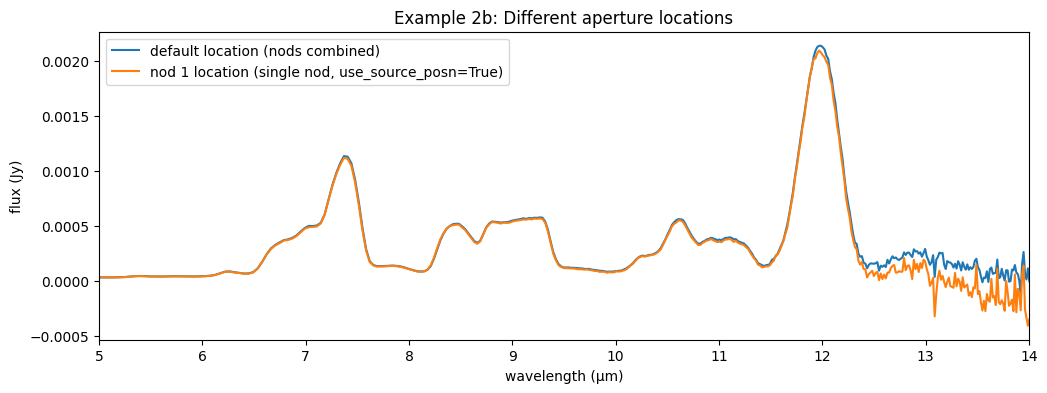

In [25]:
fig7, ax7 = plt.subplots(figsize=[12, 4])
ax7.plot(l3_spec.spec[0].spec_table['WAVELENGTH'], l3_spec.spec[0].spec_table['FLUX'], label='default location (nods combined)')
ax7.plot(sp2_ex2b.spec[0].spec_table['WAVELENGTH'], sp2_ex2b.spec[0].spec_table['FLUX'], label='nod 1 location (single nod, use_source_posn=True)')
ax7.set_xlabel('wavelength (μm)')
ax7.set_ylabel('flux (Jy)')
ax7.set_title('Example 2b: Different aperture locations')
ax7.set_xlim(5., 14.)
ax7.legend()
fig7.show()

<hr style="border:1px solid gray"> </hr>

## Example 3: Extraction with background subtraction<a class="anchor" id="ex3"></a>

For LRS slit observations, the default background subtraction strategy is performed in the ``background`` step in Spec2Pipeline; the 2 nodded exposures are mutually subtracted, resulting in a pair of ``s2d`` files each containing a background-subtracted 2D spectral image with a positive and a negative trace. This approach is optimized for point sources, and the current flux calibration of the JWST pipeline is benchmarked to yield the correct flux level when using this method.

For non-standard cases, however, it may be desirable to skip the mutual nodded exposure subtraction step and instead subtract the background directly from the spectral image as part of the spectral extraction in ``extract_1d``. For example, LRS observations of extended sources or scenes with multiple sources within the slit (e.g., binary stars) are not well-suited for the default background subtraction step and require extra care to isolate the signal from the desired target. 

In the ``extract_1d`` reference file, we can pass specific parameters for the background subtraction. The most important consideration is the background region from which the background flux level will be modeled. Care should be taken to ensure that the background region avoids astrophysical signal from sources within the slit, while simultaneously being extensive enough to provide a reliable representation of the background level. 

For this example, we will use the Level 2 ``s2d`` spectral image produced without nod subtraction: ``l2_s2d_file_nobsub``. Let us examine the flux distribution in the cross-dispersion direction for a select number of rows.


/var/folders/15/2bqy5cl94jq15mlyt1vnkls40005sl/T/ipykernel_34091/654790159.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig8.show()


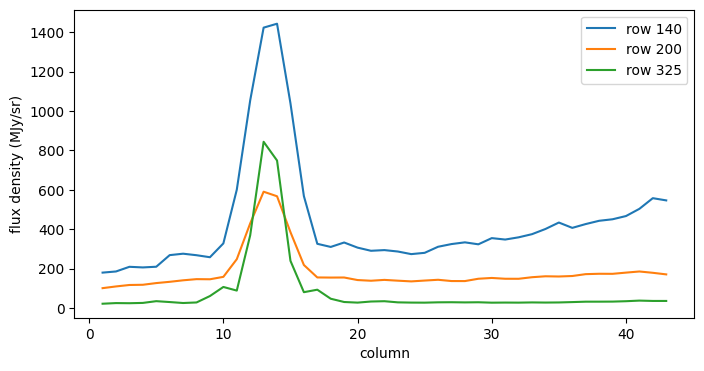

In [26]:
l2_s2d_nobsub = datamodels.open(l2_s2d_file_nobsub)

rows = [140, 200, 325]
fig8, ax8 = plt.subplots(figsize=[8, 4])
ncols = np.shape(l2_s2d_nobsub.data)[1]
pltx = np.arange(ncols)
for rr in rows:
    label = 'row {}'.format(rr)
    ax8.plot(pltx, l2_s2d_nobsub.data[rr, :], label=label)
ax8.set_xlabel('column')
ax8.set_ylabel('flux density (MJy/sr)')
ax8.legend()
fig8.show()

From the plot, it is evident that the background level is not uniform in the cross-dispersion direction across the spectral image, particularly at long wavelengths (i.e., lower row numbers), where it rises from left to right. To estimate the backgound level in the region of the spectral trace, let's establish two background regions on either side of the source. The location of peak flux is located around columns 13-14, so we will take columns 1-6 and 21-26 (inclusive) as the background regions. 

Let's visualize the background regions.

/var/folders/15/2bqy5cl94jq15mlyt1vnkls40005sl/T/ipykernel_34091/2399789769.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig8.show()


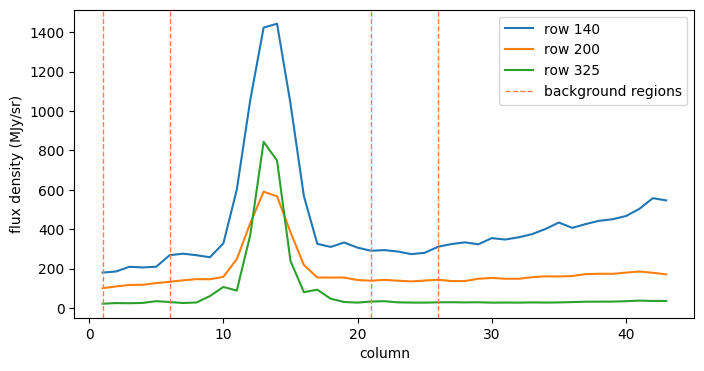

In [27]:
fig8, ax8 = plt.subplots(figsize=[8, 4])
ncols = np.shape(l2_s2d_nobsub.data)[1]
pltx = np.arange(ncols)
for rr in rows:
    label = 'row {}'.format(rr)
    ax8.plot(pltx, l2_s2d_nobsub.data[rr, :], label=label)
ax8.axvline(x=1, ymin=0, ymax=1, ls='--', lw=1., color='coral', label='background regions')
ax8.axvline(x=6, ymin=0, ymax=1, ls='--', lw=1., color='coral')
ax8.axvline(x=21, ymin=0, ymax=1, ls='--', lw=1., color='coral')
ax8.axvline(x=26, ymin=0, ymax=1, ls='--', lw=1., color='coral')
ax8.set_xlabel('column')
ax8.set_ylabel('flux density (MJy/sr)')
ax8.legend()
fig8.show()

Having chosen the desired background region, we use the ``bkg_coeff`` parameter to pass our selection to the ``extract_1d`` step. It is important to note that the pixel coordinate convention in ``bkg_coeff`` is somewhat different than for ``xstart`` and ``xstop``. For typical use cases, ``xstart`` and ``xstop`` are integers, which correspond to the whole pixels on the detector, i.e., the aperture boundary extends from the left edge of the ``xstart`` pixel to the right edge of the ``xstop`` pixel. In contrast, ``bkg_coeff`` assumes exact pixel coordinates, where a whole number pixel value cooresponds to the geometric center of that pixel on the detector. Therefore, in order to include the full pixels within the two column ranges defined above, we must use the pixel boundary coordinates 0.5, 6.5, 20.5, and 26.5. 

The ``bkg_coeff`` parameter consists of a list of lists, where each list in the collection is a set of coefficients for a polynomial boundary along the vertical axis. Here, because we are using simple vertical lines as boundaries, each list consists of just a single number, corresponding to a pixel location. 

The ``bkg_fit`` parameter instructs the pipeline on the method of background modeling per row. The possible choices are 'mean', 'median', and 'poly'. Given that the background flux distribution is quasilinear, we will choose 'poly'. If 'poly' is chosen, the user must also define the order of the polynomial via the ``bkg_order`` parameter; in this case, we set it to 1, for a linear fit.

In [28]:
with open(json_ref_default) as json_ref:
    x1dref_default = json.load(json_ref)
    x1dref_ex3 = x1dref_default.copy()
    x1dref_ex3['apertures'][0]['use_source_posn'] = False
    x1dref_ex3['apertures'][0]['xstart'] = xstart3
    x1dref_ex3['apertures'][0]['xstop'] = xstop3
    x1dref_ex3['apertures'][0]['bkg_coeff'] = [[0.5], [6.5], [20.5], [26.5]]
    x1dref_ex3['apertures'][0]['bkg_fit'] = 'poly'
    x1dref_ex3['apertures'][0]['bkg_order'] = 1

with open('x1d_reffile_example3a.json', 'w') as jsrefout:
    json.dump(x1dref_ex3, jsrefout, indent=4)

In [29]:
sp2_ex3a = Extract1dStep.call(l2_s2d_file_nobsub, output_dir='data/', output_file='lrs_slit_extract_example3a',
                             override_extract1d='x1d_reffile_example3a.json')

2025-12-17 13:31:18,574 - stpipe.step - INFO - Extract1dStep instance created.
2025-12-17 13:31:18,623 - stpipe.step - INFO - Step Extract1dStep running with args ('data/jw02072001001_06101_00001_mirimage_s2d_nobsub.fits',).
2025-12-17 13:31:18,626 - stpipe.step - INFO - Step Extract1dStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: /Users/iwong/Documents/Astro/STScI/pipeline_testing/jdat_notebooks/notebooks/MIRI/MIRI_LRS_spectral_extraction/lrs_slit_extract_example3a
  output_dir: data/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: False
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  subtract_background: None
  apply_apcorr: True
  extraction_type: box
  use_source_posn: None
  position_offset: 0.0
  model_nod_pair: True
  optimize_psf_location: True
  smoothing_length: None
  bkg_fit: None
  bkg_order: None
  log_increment: 50
  save_profile: False
  save_scene_model: False
  save_residual_image: 

When the ``extract_1d`` step performs a background subtraction, the background spectrum is part of the output product, so we can check what was subtracted. In the plot below, we compare the spectrum extracted using in-scene background subtraction of the Level 2 spectral image without pipeline nod subtraction to the one we previously derived from the nod-subtracted image (with no additional background removal).

/var/folders/15/2bqy5cl94jq15mlyt1vnkls40005sl/T/ipykernel_34091/3640758313.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig9.show()


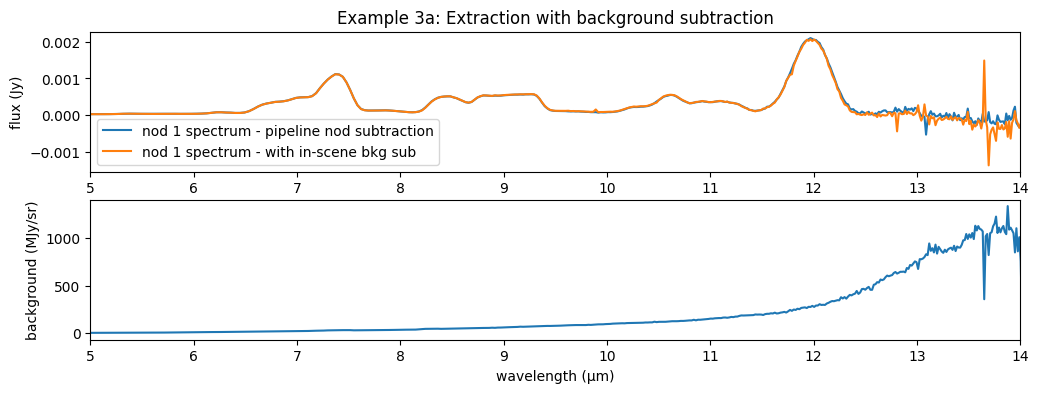

In [30]:
fig9, ax9 = plt.subplots(nrows=2, ncols=1, figsize=[12, 4])
ax9[0].plot(sp2_ex2a.spec[0].spec_table['WAVELENGTH'], sp2_ex2a.spec[0].spec_table['FLUX'], label='nod 1 spectrum - pipeline nod subtraction')
ax9[0].plot(sp2_ex3a.spec[0].spec_table['WAVELENGTH'], sp2_ex3a.spec[0].spec_table['FLUX'], label='nod 1 spectrum - with in-scene bkg sub')
ax9[1].plot(sp2_ex3a.spec[0].spec_table['WAVELENGTH'], sp2_ex3a.spec[0].spec_table['BACKGROUND'])
ax9[1].set_xlabel('wavelength (μm)')
ax9[0].set_ylabel('flux (Jy)')
ax9[1].set_ylabel('background (MJy/sr)')
ax9[0].set_title('Example 3a: Extraction with background subtraction')
ax9[0].set_xlim(5., 14.)
ax9[1].set_xlim(5., 14.)
ax9[0].legend()
fig9.show()

The two spectra are largely comparable. It is important to recall that the current photometric calibration of the LRS slit is based on nod-subtracted Level 3 products. At the longest wavelengths, where the PSF of the spectral trace broadens considerably, there is nonnegligible overlap between the two nodded spectral profiles. In other words, when carrying out the nod subtraction, some fraction of the target flux in Nod 2 is removed from the Nod 1 spectrum, and vice versa. The aperture correction accounts for this during standard pipeline processing. However, when producing custom spectra from ``s2d`` files without nod subtraction, there will be some bias in the overall flux level of the extracted spectra due to the discrepant processing workflows. Users that require accurate absolute flux measurements should therefore recalibrate the flux levels by extracting the spectra of standard stars using an analogous methodology and comparing them to stellar model spectra.

From the figure, we can see that the background level rises steeply at long wavelengths, consistent with our earlier inspection of the spectral image. We also note some significant jitter at long wavelengths, likely due to bad pixels and generally poorer SNR. It may be helpful to smooth the background model to lessen the impact of these pixel-to-pixel variations while preserving the overall trend with wavelength. This can be accomplished by using the ``smoothing_length`` parameter, which provides the width of the boxcar kernel used for smoothing the background regions along the dispersion direction; the parameter must be an odd integer.

In [31]:
with open(json_ref_default) as json_ref:
    x1dref_default = json.load(json_ref)
    x1dref_ex3 = x1dref_default.copy()
    x1dref_ex3['apertures'][0]['use_source_posn'] = False
    x1dref_ex3['apertures'][0]['xstart'] = xstart3
    x1dref_ex3['apertures'][0]['xstop'] = xstop3
    x1dref_ex3['apertures'][0]['bkg_coeff'] = [[0.5], [6.5], [20.5], [26.5]]
    x1dref_ex3['apertures'][0]['bkg_fit'] = 'poly'
    x1dref_ex3['apertures'][0]['bkg_order'] = 1
    x1dref_ex3['apertures'][0]['smoothing_length'] = 21

with open('x1d_reffile_example3b.json', 'w') as jsrefout:
    json.dump(x1dref_ex3, jsrefout, indent=4)

In [32]:
sp2_ex3b = Extract1dStep.call(l2_s2d_file_nobsub, output_dir='data/', output_file='lrs_slit_extract_example3b',
                             override_extract1d='x1d_reffile_example3b.json')

2025-12-17 13:31:19,094 - stpipe.step - INFO - Extract1dStep instance created.
2025-12-17 13:31:19,140 - stpipe.step - INFO - Step Extract1dStep running with args ('data/jw02072001001_06101_00001_mirimage_s2d_nobsub.fits',).
2025-12-17 13:31:19,142 - stpipe.step - INFO - Step Extract1dStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: /Users/iwong/Documents/Astro/STScI/pipeline_testing/jdat_notebooks/notebooks/MIRI/MIRI_LRS_spectral_extraction/lrs_slit_extract_example3b
  output_dir: data/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: False
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  subtract_background: None
  apply_apcorr: True
  extraction_type: box
  use_source_posn: None
  position_offset: 0.0
  model_nod_pair: True
  optimize_psf_location: True
  smoothing_length: None
  bkg_fit: None
  bkg_order: None
  log_increment: 50
  save_profile: False
  save_scene_model: False
  save_residual_image: 

/var/folders/15/2bqy5cl94jq15mlyt1vnkls40005sl/T/ipykernel_34091/1697654453.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig9.show()


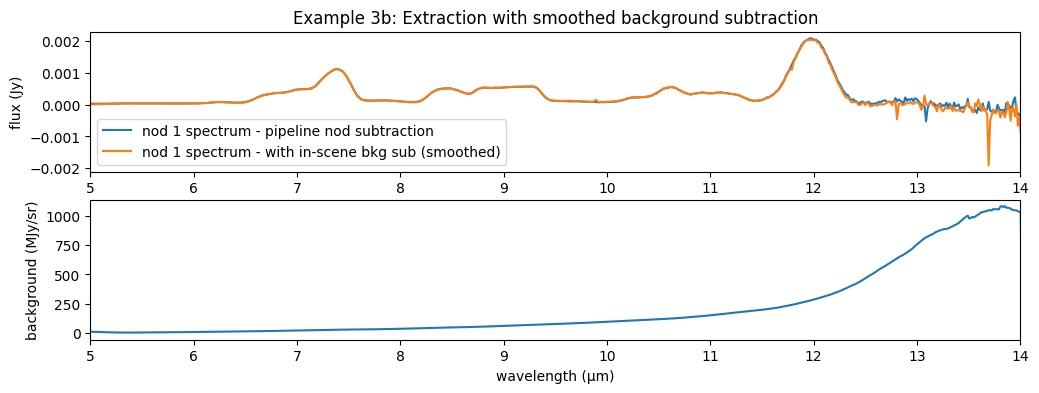

In [33]:
fig9, ax9 = plt.subplots(nrows=2, ncols=1, figsize=[12, 4])
ax9[0].plot(sp2_ex2a.spec[0].spec_table['WAVELENGTH'], sp2_ex2a.spec[0].spec_table['FLUX'], label='nod 1 spectrum - pipeline nod subtraction')
ax9[0].plot(sp2_ex3b.spec[0].spec_table['WAVELENGTH'], sp2_ex3b.spec[0].spec_table['FLUX'], label='nod 1 spectrum - with in-scene bkg sub (smoothed)')
ax9[1].plot(sp2_ex3b.spec[0].spec_table['WAVELENGTH'], sp2_ex3b.spec[0].spec_table['BACKGROUND'])
ax9[1].set_xlabel('wavelength (μm)')
ax9[0].set_ylabel('flux (Jy)')
ax9[1].set_ylabel('background (MJy/sr)')
ax9[0].set_title('Example 3b: Extraction with smoothed background subtraction')
ax9[0].set_xlim(5., 14.)
ax9[1].set_xlim(5., 14.)
ax9[0].legend()
fig9.show()

As expected, the modeled background array and background-corrected spectrum are considerably smoother. The residual outliers in the extracted spectrum are likely caused by bad pixels within the extraction aperture, which cannot be directly addressed through the ``extract_1d`` step and must be dealt with separately.

<hr style="border:1px solid gray"> </hr>

## Example 4: Tapered column extraction<a class="anchor" id="ex4"></a>

The ``extract_1d`` reference file supports variable apertures that change as a function of pixel position or wavelength. In this example, we will use the JWST calibration pipeline to perform a spectral extraction with a tapered column aperture that grows wider as a function of wavelength, mirroring the broadening of the spectral trace PSF. Specifically, we want to set the aperture width to 3 times the FWHM of the spatial profile. The way to specify this in the reference file is to use the ``src_soeff`` parameter instead of the simpler ``xstart`` and ``xstop`` settings. The ``src_coeff`` parameter can take polynomial coefficients rather than fixed pixel values.

Polynomial definitions for the extraction aperture can be specified as a function of either pixels or wavelength. The particular choice must be denoted using the ``independent_var`` parameter. We will use pre-measured FWHM values as a function of **wavelength** and fit a straight line to the FWHM($\lambda$) profile. Of course, the FWHM can also be measured directly from the data. 

In [34]:
def calc_xap_fit():
    # FWHM values measured from commissioning data. FWHM is in arcsec.
    lam = [5.0, 7.5, 10.0, 12.0]
    fwhm = [0.29, 0.3, 0.36, 0.42]

    # Convert FWHM from arcsec to pixel units using the MIRI pixel scale of 0.11 arcsec/px
    fwhm_px = fwhm / (0.11*u.arcsec/u.pixel)

    # Define a aperture with width of 3 * FWHM width, i.e., 1.5 * FWHM on either side of the trace
    xap_pix = 1.5 * fwhm_px

    # Fit a line to these points
    line_init = models.Linear1D()
    fit = fitting.LinearLSQFitter()
    fitted_line = fit(line_init, lam, xap_pix.value)

    # Plot
    fig, ax = plt.subplots(figsize=[8, 4])
    xplt = np.linspace(4.0, 14., num=50)
    ax.plot(lam, xap_pix.value, 'rx', label='1.5 * FWHM')
    ax.plot(xplt, fitted_line(xplt), 'b-', label='best-fit line')
    ax.set_xlabel('wavelength (μm)')
    ax.set_ylabel('aperture half-width (px)')
    ax.legend()
    fig.show()

    return fitted_line

/var/folders/15/2bqy5cl94jq15mlyt1vnkls40005sl/T/ipykernel_34091/2152325505.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


slope = 0.25795, intercept = 2.44562


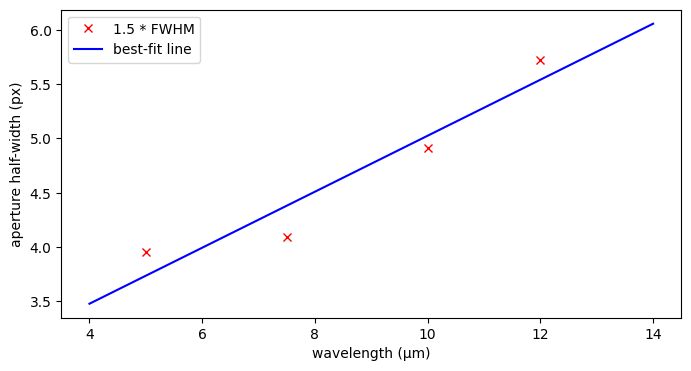

In [35]:
poly_pos = calc_xap_fit()
print('slope = {0:.5f}, intercept = {1:.5f}'.format(poly_pos.slope.value, poly_pos.intercept.value))

The above polynomial defines the relationship between wavelength and the location of the left/right boundary of the extract aperture. To ensure that the extraction location is centred on the location of the spectrum, we utilize the automatic aperture centering functionality and set ``use_source_posn`` to True.

In the next cell, we provide the polynomial coefficients to the ``src_coeff`` parameter in the extraction reference file. **Note: the ``src_coeff`` parameter takes precedence over the ``xstart`` and ``xstop`` parameters if all three are present; for clarity we remove the latter from our reference file.**

In [36]:
with open(json_ref_default) as json_ref:
    x1dref_default = json.load(json_ref)
    x1dref_ex4 = x1dref_default.copy()
    x1dref_ex4['apertures'][0]['xstart'] = None
    x1dref_ex4['apertures'][0]['xstop'] = None
    x1dref_ex4['apertures'][0]['use_source_posn'] = True
    x1dref_ex4['apertures'][0]['independent_var'] = 'wavelength'
    x1dref_ex4['apertures'][0]['src_coeff'] = [[-1*poly_pos.intercept.value, -1*poly_pos.slope.value], [poly_pos.intercept.value, poly_pos.slope.value]]

with open('x1d_reffile_example4.json', 'w') as jsrefout:
    json.dump(x1dref_ex4, jsrefout, indent=4)

In [37]:
sp3_ex4 = Extract1dStep.call(l3_s2d, output_dir='data/', 
                             output_file='lrs_slit_extract_example4', override_extract1d='x1d_reffile_example4.json')

2025-12-17 13:31:19,688 - stpipe.step - INFO - Extract1dStep instance created.
2025-12-17 13:31:19,742 - stpipe.step - INFO - Step Extract1dStep running with args (<SlitModel(388, 63) from jw02072-o001_t001_miri_p750l_s2d.fits>,).
2025-12-17 13:31:19,744 - stpipe.step - INFO - Step Extract1dStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: /Users/iwong/Documents/Astro/STScI/pipeline_testing/jdat_notebooks/notebooks/MIRI/MIRI_LRS_spectral_extraction/lrs_slit_extract_example4
  output_dir: data/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: False
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  subtract_background: None
  apply_apcorr: True
  extraction_type: box
  use_source_posn: None
  position_offset: 0.0
  model_nod_pair: True
  optimize_psf_location: True
  smoothing_length: None
  bkg_fit: None
  bkg_order: None
  log_increment: 50
  save_profile: False
  save_scene_model: False
  save_residual_im

Plotting the default Level 3 spectrum with our tapered column extraction result, we see good agreement between the two spectra. In the case of a variable aperture, the aperture correction at each wavelength is computed for the precise width of the aperture. The aperture correction reference file only stores correction vectors for interger-width apertures, so minor discrepancies may arise due to the inherent imperfection of the interpolation process when calculating the aperture correction factor for fractional pixel width apertures.

/var/folders/15/2bqy5cl94jq15mlyt1vnkls40005sl/T/ipykernel_34091/1623418189.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig10.show()


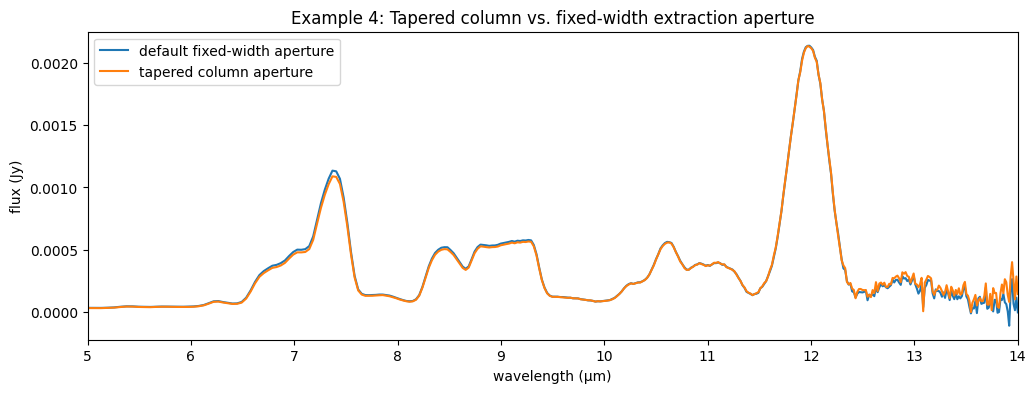

In [38]:
fig10, ax10 = plt.subplots(figsize=[12, 4])
ax10.plot(l3_spec.spec[0].spec_table['WAVELENGTH'], l3_spec.spec[0].spec_table['FLUX'], label='default fixed-width aperture')
ax10.plot(sp3_ex4.spec[0].spec_table['WAVELENGTH'], sp3_ex4.spec[0].spec_table['FLUX'], label='tapered column aperture')
ax10.set_xlabel('wavelength (μm)')
ax10.set_ylabel('flux (Jy)')
ax10.set_title('Example 4: Tapered column vs. fixed-width extraction aperture')
ax10.set_xlim(5., 14.)
ax10.legend()
fig10.show()

The output spectrum object contains information about the number of pixels used for the extraction as a function of wavelength, which we visualize below.

/var/folders/15/2bqy5cl94jq15mlyt1vnkls40005sl/T/ipykernel_34091/740784409.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig11.show()


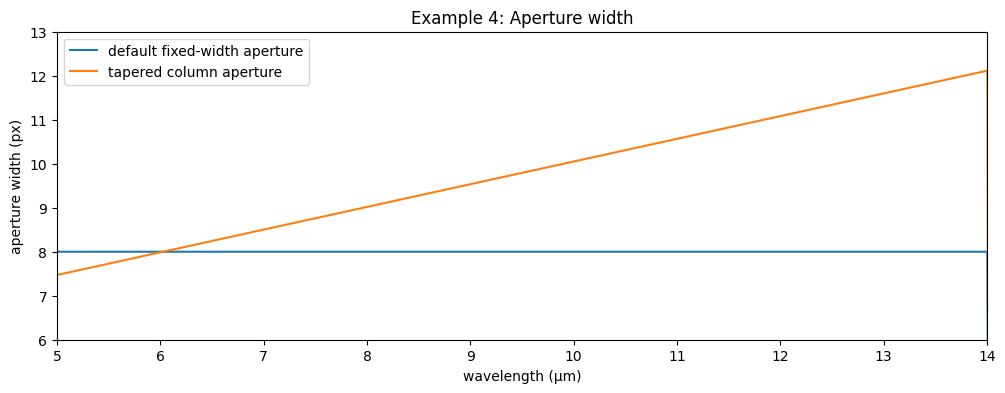

In [39]:
fig11, ax11 = plt.subplots(figsize=[12, 4])
ax11.plot(l3_spec.spec[0].spec_table['WAVELENGTH'], l3_spec.spec[0].spec_table['NPIXELS'], label='default fixed-width aperture')
ax11.plot(sp3_ex4.spec[0].spec_table['WAVELENGTH'], sp3_ex4.spec[0].spec_table['NPIXELS'], label='tapered column aperture')
ax11.set_xlabel('wavelength (μm)')
ax11.set_ylabel('aperture width (px)')
ax11.set_title('Example 4: Aperture width')
ax11.set_xlim(5., 14.)
ax11.set_ylim(6., 13.)
ax11.legend()
fig11.show()

<hr style="border:1px solid gray"> </hr>

## Example 5: Optimal spectral extraction<a class="anchor" id="ex5"></a>

As of Version 1.18.0 of the JWST calibration pipeline, the ``extract_1d`` step allows for optimal spectral extraction. A finely sampled empirical PSF model of the LRS slit spectral trace is available in CRDS and is based on high SNR observations of relatively bright point sources. Together with a spectral trace information provided in the file header, the extraction step generates a normalized PSF model for each row, which is then fit to the measured pixel values to yield the calculated flux. Because the empirical PSF in principle encapsulates the full dispersed flux of a point source at each wavelength, no aperture correction is needed.

There are several advantages of optimal spectral extraction. First, the input spectral image need not be rectified, as the algorithm leverages the spectral trace profile stored in the file header to align the PSF model in each row; this allows the user to avoid any interpolation artifacts that stem from the rectification process required to generate ``s2d`` files. Second, optimal spectral extraction is far more robust to missing data (e.g., bad pixels), cosmic rays, and point-to-point scatter and generally produces higher SNR spectra.

Currently, the optimal spectral extraction option in ``extract_1d`` only allows for unrectified spectral images of the full detector (i.e., ``cal`` files).

The parameter settings for activating optimal spectral extraction are step parameters that must be passed to the ``extract_1d`` call, as opposed to settings contained in the ``extract_1d`` reference file. Let's examine the relevant parameter settings:

* ``extraction_type``: this is the crucial toggle that instructs the ``extract_1d`` algorithm to carry out optimal spectral extraction; 'box' is the default setting, which we implicitly used for all of the other examples in this notebook.
* ``use_source_posn`` (True/False/None): setting this to True is recommended, which allows the pipeline to carry out a first-order adjustment of the PSF model to align it with the expected location of the target along the slit; this setting has the same function as the analogous one contained in the ``extract_1d`` reference file.
* ``model_nod_pair`` (True/False): must be set to True if the ``s2d`` file contains a negative trace to instruct the algorithm to model all positive and negative traces using the same empirical PSF model.
* ``optimize_psf_location`` (True/False): setting this to True is strongly recommended, given inherent uncertainties in target location and pointing accuracy. When this option is set to True, the location of the positive and negative traces (if used) are optimized with respect to the residuals of the scene modeled by the PSF at that location. This option is particularly essential when ``model_nod_pair`` is set to True, because the negative nod location is less reliably estimated than the positive trace.
* ``subtract_background`` (True/False): set to True if mutual nod subtraction was not carried out to allow the algorithm simultaneously model the background.
* ``save_scene_model`` and ``save_residual_image`` (True/False): if True, these settings generate plots of the best-fit 2D composite scene model containing the scaled PSF(s) and background used to extract the spectrum and the corresponding residuals.

We now proceed with the extraction. When ``extraction_type`` is set to 'optimal', the various parameter settings in the ``extract_1d`` reference file are ignored, as they do not factor into the optimal spectral extraction process. As a consequence, we must also stipulate ``save_results`` = True, given that we are not passing a custom reference file to the step call.

In [40]:
sp2_ex5a = Extract1dStep.call(l2_cal_file, output_dir='data/', 
                                output_file='lrs_slit_extract_example5a', 
                                extraction_type='optimal',
                                use_source_posn=True,
                                model_nod_pair=True,
                                optimize_psf_location=True,
                                save_scene_model=True,
                                save_residual_image=True,
                                save_results=True)

2025-12-17 13:31:20,290 - stpipe.step - INFO - Extract1dStep instance created.
2025-12-17 13:31:20,342 - stpipe.step - INFO - Step Extract1dStep running with args ('data/jw02072001001_06101_00001_mirimage_cal.fits',).
2025-12-17 13:31:20,344 - stpipe.step - INFO - Step Extract1dStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: /Users/iwong/Documents/Astro/STScI/pipeline_testing/jdat_notebooks/notebooks/MIRI/MIRI_LRS_spectral_extraction/lrs_slit_extract_example5a
  output_dir: data/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  subtract_background: None
  apply_apcorr: True
  extraction_type: optimal
  use_source_posn: True
  position_offset: 0.0
  model_nod_pair: True
  optimize_psf_location: True
  smoothing_length: None
  bkg_fit: None
  bkg_order: None
  log_increment: 50
  save_profile: False
  save_scene_model: True
  save_residual_image: True


Let's take a look at the various outputs produced by this run. In addition to the spectrum, there are two diagnostics image files — a ``*scene_model.fits`` file and a ``*residual.fits`` file. These are the best-fit scene (containing both the scaled positive and negative PSFs) and the associated residuals from the fit.

We plot these products below alongside the input ``cal`` spectral image. Recall that ``cal`` files contain the detector readout, whereas the LRS slit spectral region occupies only a small portion of the full array, and so we plot just the relevant subregion for inspection.

/var/folders/15/2bqy5cl94jq15mlyt1vnkls40005sl/T/ipykernel_34091/757253948.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig12.show()


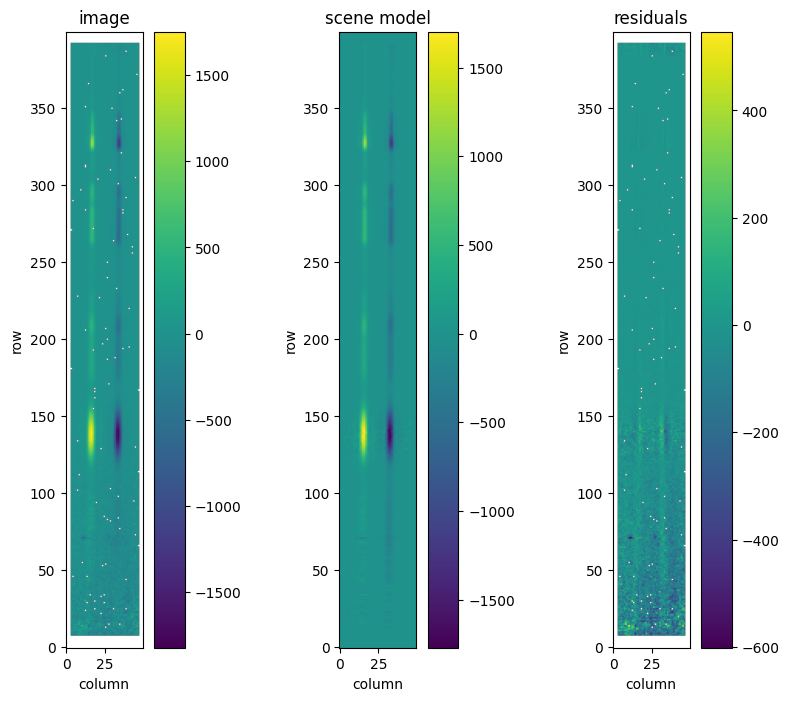

In [41]:
l2_cal = datamodels.open(l2_cal_file)
scene = datamodels.open('data/lrs_slit_extract_example5a_scene_model.fits')
resid = datamodels.open('data/lrs_slit_extract_example5a_residual.fits')

fig12, ax12 = plt.subplots(nrows=1, ncols=3, figsize=[10, 8])
im2d = ax12[0].imshow(l2_cal.data[0:400,300:350], origin='lower', aspect='equal', cmap='viridis')
fig12.colorbar(im2d)
sce2d = ax12[1].imshow(scene.data[0:400,300:350], origin='lower', aspect='equal', cmap='viridis')
fig12.colorbar(sce2d)
res2d = ax12[2].imshow(resid.data[0:400,300:350], origin='lower', aspect='equal', cmap='viridis')
fig12.colorbar(res2d)
for i in range(3):
    ax12[i].set_xlabel('column')
    ax12[i].set_ylabel('row')
ax12[0].set_title('image')
ax12[1].set_title('scene model')
ax12[2].set_title('residuals')
fig12.show()

From the residual image, we find that the optimal spectral extraction does a decent job at modeling both the positive and negative spectral traces, though there is some discernible structure. These residual features are primarily due to an imperfect spectral trace profile in the header WCS solution, resulting in systematic deviations between the assumed trace shape and the true profile. Future updates to the ``specwcs`` reference file will improve the trace model.

We now compare the spectrum we obtained through optimal extraction to the boxcar spectrum previously derived in Example 2b.

/var/folders/15/2bqy5cl94jq15mlyt1vnkls40005sl/T/ipykernel_34091/2205233284.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig13.show()


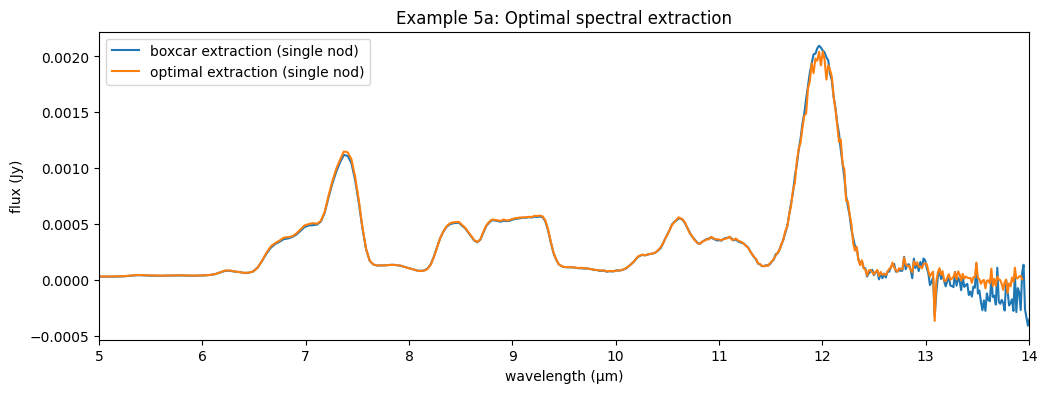

In [42]:
fig13, ax13 = plt.subplots(figsize=[12, 4])
ax13.plot(sp2_ex2b.spec[0].spec_table['WAVELENGTH'], sp2_ex2b.spec[0].spec_table['FLUX'], label='boxcar extraction (single nod)')
ax13.plot(sp2_ex5a.spec[0].spec_table['WAVELENGTH'], sp2_ex5a.spec[0].spec_table['FLUX'], label='optimal extraction (single nod)')
ax13.set_xlabel('wavelength (μm)')
ax13.set_ylabel('flux (Jy)')
ax13.set_title('Example 5a: Optimal spectral extraction')
ax13.set_xlim(5., 14.)
ax13.legend()
fig13.show()

From the plot, it is evident that optimal spectral extraction yields the greatest improvement in SNR and the most significant reduction in spectral scatter at the longest wavelengths, where the instrument throughput is low and there is a high level of point-to-point variations in flux level across the detector. The systematic deviations and enhanced scatter of the optimal extraction spectrum near the flux maximum at 12 microns are attributable to poor PSF model fitting due to the imperfect assumed spectral trace profile.

Optimal spectral extraction can also be performed with simultaneous background modeling, which is useful for cases where mutual nod subtraction has not been carried out. Here, we repeat this exercise with the ``l2_cal_file_nobsub`` file and switch ``model_nod_pair`` to False. To activate background subtraction for optimal spectral extraction, we set ``subtract_background`` as True. 

By default, the current implementation of simultaneous background fitting assumes that the background flux level in each row is constant. However, we know that this is not true in actual LRS slit images, as discussed previously. To enable more robust background modeling as part of the optimal spectral extraction process, we require a number of parameter settings to be passed to the step through the ``extract_1d`` refefrence file. These are identical to the settings used for background subtraction in boxcar extractions (see Example 3).

**Note: currently, the simultaneous background modeling is carried out row by row, without the option to smooth the background flux along the dispersion axis.** 

In [43]:
with open(json_ref_default) as json_ref:
    x1dref_default = json.load(json_ref)
    x1dref_ex5 = x1dref_default.copy()
    x1dref_ex5['apertures'][0]['bkg_fit'] = 'poly'
    x1dref_ex5['apertures'][0]['bkg_order'] = 1

with open('x1d_reffile_example5b.json', 'w') as jsrefout:
    json.dump(x1dref_ex5, jsrefout, indent=4)

We can now run ``extract_1d`` with both the customized reference file and the step parameters for optimal spectreal extraction.

In [44]:
sp2_ex5b = Extract1dStep.call(l2_cal_file_nobsub, output_dir='data/', 
                                output_file='lrs_slit_extract_example5b', override_extract1d='x1d_reffile_example5b.json',
                                extraction_type='optimal',
                                use_source_posn=True,
                                model_nod_pair=False,
                                optimize_psf_location=True,
                                subtract_background=True,
                                save_scene_model=True,
                                save_residual_image=True,
                                save_results=True)

2025-12-17 13:31:22,889 - stpipe.step - INFO - Extract1dStep instance created.
2025-12-17 13:31:22,943 - stpipe.step - INFO - Step Extract1dStep running with args ('data/jw02072001001_06101_00001_mirimage_cal_nobsub.fits',).
2025-12-17 13:31:22,945 - stpipe.step - INFO - Step Extract1dStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: /Users/iwong/Documents/Astro/STScI/pipeline_testing/jdat_notebooks/notebooks/MIRI/MIRI_LRS_spectral_extraction/lrs_slit_extract_example5b
  output_dir: data/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  subtract_background: True
  apply_apcorr: True
  extraction_type: optimal
  use_source_posn: True
  position_offset: 0.0
  model_nod_pair: False
  optimize_psf_location: True
  smoothing_length: None
  bkg_fit: None
  bkg_order: None
  log_increment: 50
  save_profile: False
  save_scene_model: True
  save_residual_imag

/var/folders/15/2bqy5cl94jq15mlyt1vnkls40005sl/T/ipykernel_34091/444863612.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig14.show()


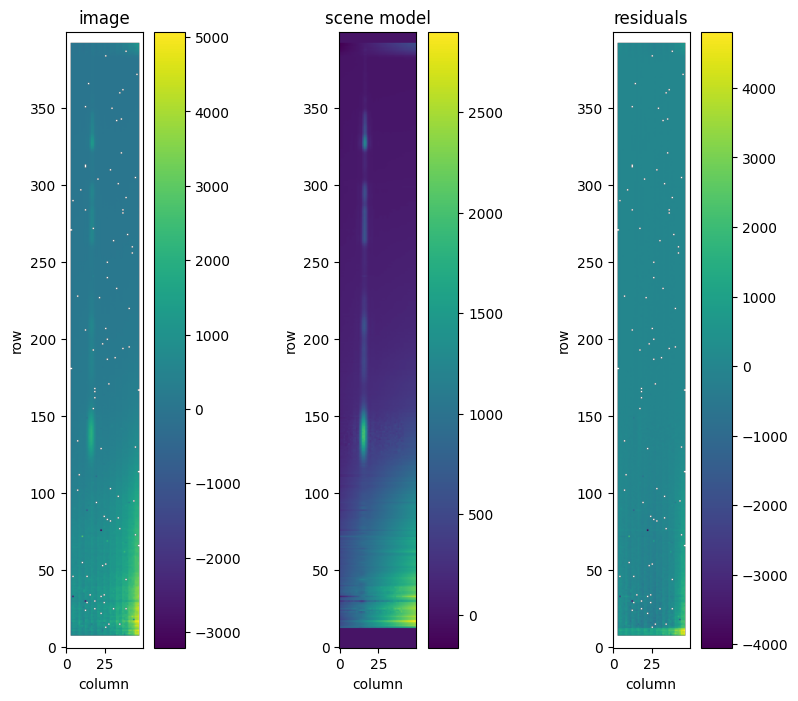

In [45]:
l2_cal = datamodels.open(l2_cal_file_nobsub)
scene = datamodels.open('data/lrs_slit_extract_example5b_scene_model.fits')
resid = datamodels.open('data/lrs_slit_extract_example5b_residual.fits')

fig14, ax14 = plt.subplots(nrows=1, ncols=3, figsize=[10, 8])
im2d = ax14[0].imshow(l2_cal.data[0:400,300:350], origin='lower', aspect='equal', cmap='viridis')
fig14.colorbar(im2d)
sce2d = ax14[1].imshow(scene.data[0:400,300:350], origin='lower', aspect='equal', cmap='viridis')
fig14.colorbar(sce2d)
res2d = ax14[2].imshow(resid.data[0:400,300:350], origin='lower', aspect='equal', cmap='viridis')
fig14.colorbar(res2d)
for i in range(3):
    ax14[i].set_xlabel('column')
    ax14[i].set_ylabel('row')
ax14[0].set_title('image')
ax14[1].set_title('scene model')
ax14[2].set_title('residuals')
fig14.show()

As illustrated in the plotted scene model, the fitted background largely reproduces the nonuniform distribution across the detector, with the flux rising toward the lower right corner of the LRS slit region. The resultant residual image is mostly absent of significant gradients, demonstrating the efficacy of this approach.

Let's compare the result of this run with the spectrum from Example 3b, i.e., the boxcar extraction that used a similar linear background modeling approach but with background smoothing in the dispersion direction.

/var/folders/15/2bqy5cl94jq15mlyt1vnkls40005sl/T/ipykernel_34091/946091776.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig15.show()


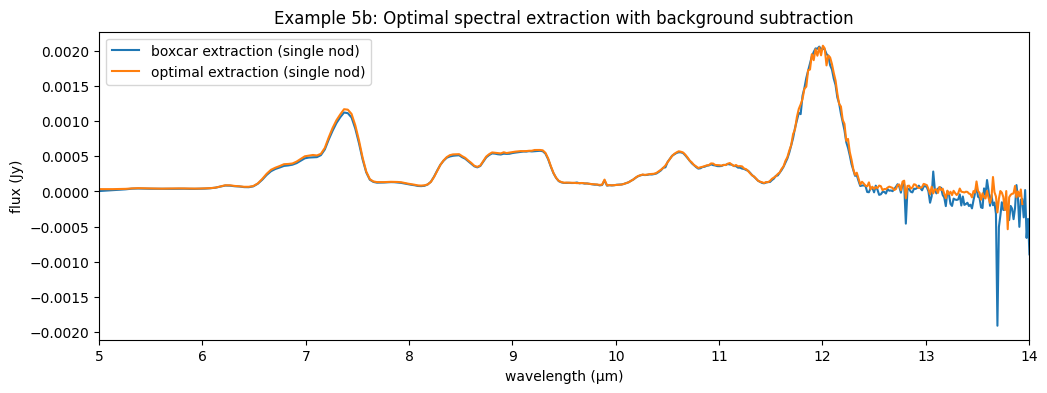

In [46]:
fig15, ax15 = plt.subplots(figsize=[12, 4])
ax15.plot(sp2_ex3b.spec[0].spec_table['WAVELENGTH'], sp2_ex3b.spec[0].spec_table['FLUX'], label='boxcar extraction (single nod)')
ax15.plot(sp2_ex5b.spec[0].spec_table['WAVELENGTH'], sp2_ex5b.spec[0].spec_table['FLUX'], label='optimal extraction (single nod)')
ax15.set_xlabel('wavelength (μm)')
ax15.set_ylabel('flux (Jy)')
ax15.set_title('Example 5b: Optimal spectral extraction with background subtraction')
ax15.set_xlim(5., 14.)
ax15.legend()
fig15.show()

The optimal spectral extraction result is a significant improvement over the boxcar extraction spectrum, even with background smoothing applied to the latter. Moreover, the simultaneous background modeling and subtraction partially accounts for the previously observed mismatch in flux level near 12 microns when carrying out optimal spectral extraction on the nod-subtracted image. However, the fundamental issue of the misaligned trace profile persists and will be addressed in future updates.

We note that ``subtract_background`` can be activated even if mutual nod subtraction has been performed. In that case, the background modeling can account for any residual background arising from differences in the background flux distribution between the two nodded exposures.

<hr style="border:1px solid gray"> </hr>

## Summary

We hope this notebook is useful in demonstrating the advanced capabilities of the JWST calibration pipeline for spectral extraction of MIRI LRS slit datasets. The techniques described here are largely transferable to the analysis of other types of spectroscopic data from JWST, including MIRI LRS slitless and NIRSpec fixed slit observations. The above examples are not an exhaustive list of all possible use cases, and different methods for source and background extraction can be combined for even more complex extraction operations. 

**If you have any questions, comments, or requests for further demonstrations of these capabilities, please contact the [JWST Helpdesk](http://jwsthelp.stsci.edu/).**

<hr style="border:1px solid gray"> </hr>